In [276]:
%%capture
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

!pip install dask_cuda dask-cudf-cu12

In [277]:
%%capture
!pip install catboost pytorch_lightning

In [278]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [279]:
import matplotlib.pyplot as plt
%matplotlib inline

import cudf
import cupy as cp
import numpy as np

from numba import cuda

# Домашнее задание \ проект

В данном проекте вам нужно будет провести стандартную работу - загрузить данные, поисследовать их, сделать модельку. Сразу оговорюсь, что подбор параметров, интересные архитектуры...на это я внимания обращать не буду, у нас курс не про ML. Главное - это использования GPU. Что нужно?

    1) Загрузить данны при помощи cudf\dask-cudf
    2) Произвести базовый анализ данных (распределение классов, средние значения фичей по классам и вот это вот все). Любые преобразования данных на ваше усмотрение (только комментируйте=) )
    3) Попробуйте в ходе анализа \ обработки найти применение cuda.jit и cupy (достаточно по 1 примеру, даже искуственному)
    4) Взять два метода снижения размерности из cuml (на лекции был UMAP, еще есть tSNE, tSVD, PCA...), обучить их и визуализировать наши классы в пространстве размерности 2 (раскрасить классы будет хорошей идеей)
    5) Обучите нейронку на GPU\Multi-GPU, а также какую-нибудь еще модельку на GPU\Multi-GPU.

P.S. прошу в коде давать комментарии того, что делаете. Пункты 4 и 5 также зачту за домашку 3 занятия.

Данные находятся в файле Train_Set_90621.csv
Amount Defaulted - эту переменную нужно удалить

И все на GPU, никаких любимых pandas, numpy и прочего))

Цель всего этого - чтобы вы побольше поипользовали GPU

### 1). Загрузка данных

Загрузка данных и удаление Amount Defaulted

In [280]:
data = cudf.read_csv('Train_Set_90621.csv')

In [281]:
data = data.drop(columns=['Amount Defaulted'])

### 2). Анализ данных и заполнение пропусков

Общая информация

In [282]:
data.describe()

,Application ID,Business_Industry_Type_Code,Approved_Year,New Business,Term,Interest Rate,Employees,Gross Disbursed Amount,Term_years,Jobs Retained,Male to Female Employees Ratio,Expected Company Income,Funds available with company,Gross_Apprv_Amount,Company Branch Code,City or Rural,Jobs Generated,Balance Left,Final_Appved_Amount,Default_Status
count,1.951180e+05,195118.000000,195118.000000,195082.000000,195118.000000,195118.000000,195118.000000,1.951180e+05,195118.000000,195118.000000,195118.000000,1.951150e+05,1.951180e+05,1.951180e+05,195118.000000,195118.000000,195118.000000,1.951180e+05,1.951180e+05,195118.000000
mean,1.020298e+09,399104.705988,2008.122751,1.279303,110.739860,7.327914,19.122982,1.414492e+07,9.245462,11.418362,15.329211,1.832522e+07,1.253179e+06,1.356561e+07,2812.721502,0.754697,9.055151,9.184186e+00,1.052898e+07,0.180598
std,5.632586e+04,263815.889671,6.256458,0.451119,78.851772,2.977714,130.032607,2.029931e+07,6.569699,248.744198,11.791947,1.759069e+08,6.455671e+05,1.996955e+07,12897.919613,0.646914,248.317037,3.962911e+03,1.610177e+07,0.384686
min,1.020200e+09,1230.000000,1900.000000,0.000000,0.000000,2.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,1.000020e+05,1.400000e+04,0.000000,0.000000,0.000000,0.000000e+00,7.000000e+03,0.000000
25%,1.020249e+09,236341.000000,2005.000000,1.000000,60.000000,5.000000,3.000000,2.944498e+06,5.000000,0.000000,7.000000,5.000000e+05,6.995165e+05,2.450000e+06,1.000000,0.000000,0.000000,0.000000e+00,1.487500e+06,0.000000
50%,1.020298e+09,446541.000000,2009.000000,1.000000,84.000000,7.000000,7.000000,7.000000e+06,7.000000,1.000000,13.000000,1.500000e+06,1.239653e+06,6.300000e+06,1.000000,1.000000,0.000000,0.000000e+00,4.375000e+06,0.000000
75%,1.020346e+09,562961.000000,2011.000000,2.000000,120.000000,10.000000,17.000000,1.673000e+07,10.000000,4.000000,19.000000,7.200000e+06,1.778303e+06,1.589000e+07,1.000000,1.000000,1.000000,0.000000e+00,1.225000e+07,0.000000
max,1.020395e+09,929351.000000,2017.000000,2.000000,461.000000,12.000000,22222.000000,7.325500e+08,38.000000,8800.000000,50.000000,4.320000e+10,2.500000e+06,3.500000e+08,92000.000000,2.000000,8800.000000,1.750000e+06,3.150000e+08,1.000000


In [283]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
numeric_columns = [col for col in numeric_columns if col != 'Default_Status']

Подсчет процентного соотношения и отображение количества по Default_Status

In [284]:
total_count = len(data)
percentages = data.groupby("Default_Status").size().reset_index(name="count")
percentages["percentage"] = (percentages["count"] / total_count).round(2)
print(percentages)

   Default_Status   count  percentage
0               0  159880        0.82
1               1   35238        0.18


Статистика для числовых столбцов

In [285]:
print("\nСтатистики для числовых столбцов:")
for col in numeric_columns:
    mean = data[col].mean()
    median = data[col].median()
    std = data[col].std()
    print(f"Статистика для {col}:")
    print(f"  Среднее: {mean}")
    print(f"  Медиана: {median}")
    print(f"  Стандартное отклонение: {std}")


Статистики для числовых столбцов:
Статистика для Application ID:
  Среднее: 1020297559.5
  Медиана: 1020297559.5
  Стандартное отклонение: 56325.859922419295
Статистика для Business_Industry_Type_Code:
  Среднее: 399104.7059881713
  Медиана: 446541.0
  Стандартное отклонение: 263815.8896713592
Статистика для Approved_Year:
  Среднее: 2008.122751360715
  Медиана: 2009.0
  Стандартное отклонение: 6.256458086972736
Статистика для New Business:
  Среднее: 1.2793030623020063
  Медиана: 1.0
  Стандартное отклонение: 0.45111900679753436
Статистика для Term:
  Среднее: 110.73985998216465
  Медиана: 84.0
  Стандартное отклонение: 78.85177234496568
Статистика для Interest Rate:
  Среднее: 7.327914390266403
  Медиана: 7.0
  Стандартное отклонение: 2.977713774797786
Статистика для Employees:
  Среднее: 19.122981990385306
  Медиана: 7.0
  Стандартное отклонение: 130.03260689491415
Статистика для Gross Disbursed Amount:
  Среднее: 14144916.44937935
  Медиана: 7000000.0
  Стандартное отклонение: 202

Подсчет значений null

In [286]:
null_counts = data.isnull().sum().reset_index()
null_counts.columns = ['column', 'null_count']
print(null_counts)

                            column  null_count
0                   Application ID           0
1                      Bank Masked          80
2                        Bank Type          80
3               Approved_Timestamp         426
4                      Name Masked           1
5             Business Owner State           3
6      Business_Industry_Type_Code           0
7                    Approved_Year           0
8                     New Business          36
9                             Term           0
10                       BankState          81
11                   Interest Rate           0
12                       Employees           0
13          Gross Disbursed Amount           0
14                      Term_years           0
15                   Jobs Retained           0
16  Male to Female Employees Ratio           0
17         Expected Company Income           3
18    Funds available with company           0
19              Gross_Apprv_Amount           0
20           

Заполнение значений null

In [287]:
data = data.fillna({
    'Bank Masked': 'Unknown',
    'Bank Type': 'Unknown',
    'Approved_Timestamp': 'Unknown',
    'Name Masked': 'Unknown',
    'Business Owner State': 'Unknown',
    'BankState': 'Unknown',
    'Carry-forward Credit': 'N',
    'Documents Provided': 'N'
})

In [288]:
numeric_cols_to_impute = ["New Business", "Expected Company Income"]
for col in numeric_cols_to_impute:
    mean_value = data[col].mean()
    if data[col].dtype == np.int64:
        mean_value = int(round(mean_value))
    data[col] = data[col].fillna(mean_value)

Повторный подсчет значений null

In [289]:
null_counts = data.isnull().sum().reset_index()
null_counts.columns = ['column', 'null_count']
print(null_counts)

                            column  null_count
0                   Application ID           0
1                      Bank Masked           0
2                        Bank Type           0
3               Approved_Timestamp           0
4                      Name Masked           0
5             Business Owner State           0
6      Business_Industry_Type_Code           0
7                    Approved_Year           0
8                     New Business           0
9                             Term           0
10                       BankState           0
11                   Interest Rate           0
12                       Employees           0
13          Gross Disbursed Amount           0
14                      Term_years           0
15                   Jobs Retained           0
16  Male to Female Employees Ratio           0
17         Expected Company Income           0
18    Funds available with company           0
19              Gross_Apprv_Amount           0
20           

Топ 5 значений для категориальных столбцов

In [290]:
categorical_columns = data.select_dtypes(include=['object', 'bool']).columns
for col in categorical_columns:
    print(f"\nТоп 5 значений для {col}:")
    top_5 = data[col].value_counts().nlargest(5).reset_index()
    top_5.columns = [col, 'count']
    print(top_5)


Топ 5 значений для Bank Masked:
      Bank Masked  count
0    Bank_Name_42   9133
1     Bank_Name_3   6688
2  Bank_Number_13   6021
3    Bank_Name_11   4903
4  Bank_Number_37   4436

Топ 5 значений для Bank Type:
  Bank Type   count
0   Private  130150
1      Govt   64888
2   Unknown      80

Топ 5 значений для Approved_Timestamp:
  Approved_Timestamp  count
0            Unknown    426
1         13-07-2009    210
2         15-09-2011    157
3         16-09-2011    152
4         31-05-2011    150

Топ 5 значений для Name Masked:
          Name Masked  count
0    Business_Name_39     91
1   Business_Name_355     30
2  Business_Name_1807     28
3  Business_Name_2404     28
4  Business_Name_2602     27

Топ 5 значений для Business Owner State:
  Business Owner State  count
0                Delhi  58546
1              Haryana  56421
2          Maharashtra  48088
3        Uttar Pradesh  24167
4               Orissa   2603

Топ 5 значений для BankState:
       BankState  count
0          Del

Средние занчения числовых признаков относительно Default_Status

In [291]:
for col in numeric_columns:
    if col != 'Default_Status':
        print(f"\nСреднее значение {col} для классов Default_Status:")
        print(data.groupby('Default_Status')[col].mean())


Среднее значение Application ID для классов Default_Status:
Default_Status
0    1.020298e+09
1    1.020298e+09
Name: Application ID, dtype: float64

Среднее значение Business_Industry_Type_Code для классов Default_Status:
Default_Status
0    398862.625888
1    400203.059084
Name: Business_Industry_Type_Code, dtype: float64

Среднее значение Approved_Year для классов Default_Status:
Default_Status
0    2008.108913
1    2008.185538
Name: Approved_Year, dtype: float64

Среднее значение New Business для классов Default_Status:
Default_Status
0    1.277008
1    1.289432
Name: New Business, dtype: float64

Среднее значение Term для классов Default_Status:
Default_Status
0    118.494189
1     75.557324
Name: Term, dtype: float64

Среднее значение Interest Rate для классов Default_Status:
Default_Status
0    7.328434
1    7.325558
Name: Interest Rate, dtype: float64

Среднее значение Employees для классов Default_Status:
Default_Status
0    20.561290
1    12.597168
Name: Employees, dtype: flo

Корреляции числовых столбцов с Default_Status с использованием cupy

In [292]:
X = cp.array(data[numeric_columns].values)
y = cp.array(data['Default_Status'].values)

def correlation(x, y):
    x_mean = cp.mean(x)
    y_mean = cp.mean(y)
    return cp.sum((x - x_mean) * (y - y_mean)) / cp.sqrt(cp.sum((x - x_mean)**2) * cp.sum((y - y_mean)**2))

correlations = cp.array([correlation(X[:, i], y) for i in range(X.shape[1])])
correlation_series = cudf.Series(correlations, index=numeric_columns)
sorted_correlations = correlation_series.abs().sort_values(ascending=False)

print("Корреляция с Default_Status:")
print(sorted_correlations)

Корреляция с Default_Status:
Term                              0.209472
Term_years                        0.208760
City or Rural                     0.105217
Final_Appved_Amount               0.087677
Gross_Apprv_Amount                0.079928
Gross Disbursed Amount            0.073749
Employees                         0.023561
Company Branch Code               0.016107
Male to Female Employees Ratio    0.013158
New Business                      0.010595
Jobs Retained                     0.009307
Jobs Generated                    0.009267
Approved_Year                     0.004711
Funds available with company      0.002988
Expected Company Income           0.002144
Business_Industry_Type_Code       0.001955
Balance Left                      0.000947
Application ID                    0.000490
Interest Rate                     0.000372
dtype: float64


Функция, которая вычисляет взвешенную сумму нескольких числовых столбцов и использует её для оценки риска. Использует @cuda.jit и cupy.

In [293]:
@cuda.jit
def weighted_sum_kernel(gross_amount, interest_rate, term_years, employees, income, weights, result):
    i = cuda.grid(1)
    if i < result.size:
        result[i] = (
            weights[0] * gross_amount[i] +
            weights[1] * interest_rate[i] +
            weights[2] * term_years[i] +
            weights[3] * employees[i] +
            weights[4] * income[i]
        )

def calculate_risk_score(data):
    columns = ['Gross Disbursed Amount', 'Interest Rate', 'Term_years', 'Employees', 'Expected Company Income']
    arrays = [cp.asarray(data[col]) for col in columns]
    weights = cp.array([0.3, 0.2, 0.15, 0.15, 0.2], dtype=cp.float32)

    result = cp.zeros(len(data), dtype=cp.float32)

    threads_per_block = 256
    blocks_per_grid = (len(data) + (threads_per_block - 1)) // threads_per_block

    weighted_sum_kernel[blocks_per_grid, threads_per_block](
        *[cuda.as_cuda_array(arr) for arr in arrays],
        cuda.as_cuda_array(weights),
        cuda.as_cuda_array(result)
    )

    return cudf.Series(cp.asnumpy(result))

data['Risk_Score'] = calculate_risk_score(data)

print("Статистика Risk_Score:")
print(data['Risk_Score'].describe())

print("\nСредний Risk_Score по группам Default_Status:")
print(data.groupby('Default_Status')['Risk_Score'].mean())

correlation = data['Risk_Score'].corr(data['Default_Status'])
print(f"\nКорреляция между Risk_Score и Default_Status: {correlation}")

Статистика Risk_Score:
count    1.951180e+05
mean     7.908525e+06
std      3.607528e+07
min      5.950000e+00
25%      1.316672e+06
50%      3.183336e+06
75%      7.937598e+06
max      8.644768e+09
Name: Risk_Score, dtype: float64

Средний Risk_Score по группам Default_Status:
Default_Status
0    8.155055e+06
1    6.791058e+06
Name: Risk_Score, dtype: float64

Корреляция между Risk_Score и Default_Status: -0.01454044406450168


### 3). Обработка данных

In [294]:
from cuml.preprocessing import LabelEncoder
from cuml.preprocessing import OneHotEncoder
from cuml.preprocessing import KBinsDiscretizer

Кодируем категориальные переменные

In [295]:
string_columns = ['Bank Type', 'Business Owner State', 'BankState',
                  'Carry-forward Credit', 'Documents Provided']

for col in string_columns:
    le = LabelEncoder()
    data[col + '_Index'] = le.fit_transform(data[col])

Делим численные переменные по квантилям

In [296]:
numerical_columns = ['Employees', 'Final_Appved_Amount',
                    'Approved_Year', 'Interest Rate',
                    'Gross Disbursed Amount',
                    'Term_years',
                    'Male to Female Employees Ratio',
                    'Expected Company Income',
                    'Funds available with company',
                    'Gross_Apprv_Amount']

for col in numerical_columns:
    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    data[col + '_quant'] = discretizer.fit_transform(data[[col]])

/usr/local/lib/python3.10/dist-packages/cuml/_thirdparty/sklearn/preprocessing/_discretization.py:246: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


Удаляем выбросы

In [297]:
def remove_outliers_std(df):
    for column in df.select_dtypes(include=['float64', 'int64', 'float32', 'int32', 'uint8', 'uint16']).columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        threshold = 4 * std_dev

        lower_bound = mean - threshold
        upper_bound = mean + threshold

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

In [298]:
data = remove_outliers_std(data)

### 4). UMAP и tSVD

In [299]:
numeric_columns = [
    'Business_Industry_Type_Code',
    'Approved_Year',
    'New Business',
    'Term',
    'Interest Rate',
    'Employees',
    'Gross Disbursed Amount',
    'Term_years',
    'Jobs Retained',
    'Male to Female Employees Ratio',
    'Expected Company Income',
    'Funds available with company',
    'Gross_Apprv_Amount',
    'Company Branch Code',
    'City or Rural',
    'Jobs Generated',
    'Balance Left',
    'Final_Appved_Amount',
    'Carry-forward Credit_Index',
    'Documents Provided_Index',
    "Employees_quant",
    "Final_Appved_Amount_quant",
    "Approved_Year_quant",
    "Interest Rate_quant",
    "Gross Disbursed Amount_quant",
    "Term_years_quant",
    "Male to Female Employees Ratio_quant",
    "Expected Company Income_quant",
    "Funds available with company_quant",
    "Gross_Apprv_Amount_quant"
]

UMAP

In [300]:
from cuml.manifold.umap import UMAP as cuUMAP

In [301]:
X = cp.array(data[numeric_columns].values)
y = cp.array(data['Default_Status'].values)

In [302]:
umap = cuUMAP(n_components=2, n_neighbors=15, min_dist=0.1)
umap_result = umap.fit_transform(X)

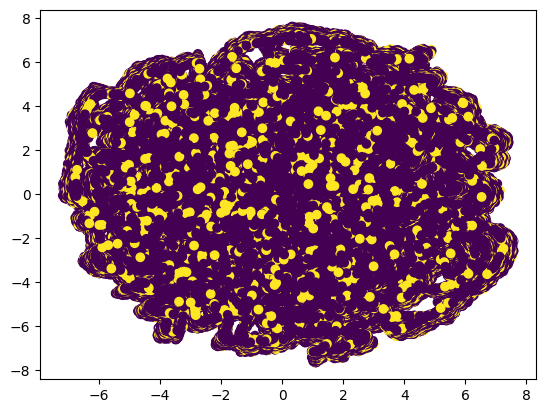

In [303]:
a, b = zip(*umap_result.tolist())
a = cp.asnumpy(a)
b = cp.asnumpy(b)
y_np = cp.asnumpy(y)

plt.scatter(a, b, c=y_np)

tSVD

In [304]:
from cuml.decomposition import TruncatedSVD as cuTSVD

In [305]:
tsvd = cuTSVD(n_components=2)
tsvd_result = tsvd.fit_transform(X)

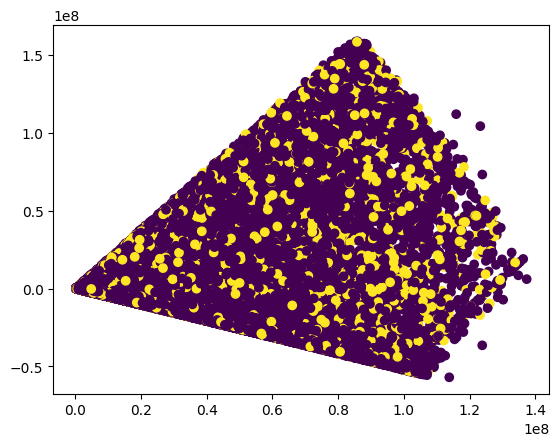

In [306]:
a, b = zip(*tsvd_result.tolist())
a = cp.asnumpy(a)
b = cp.asnumpy(b)

plt.scatter(a, b, c=y_np)

PCA

In [307]:
from cuml.decomposition import PCA as cuPCA

In [308]:
pca = cuPCA(n_components=2)
pca_result = pca.fit_transform(X)

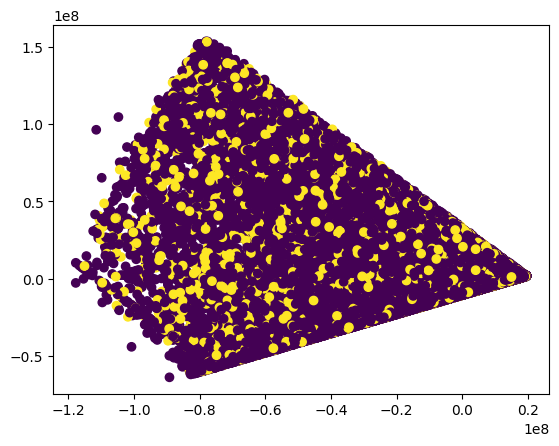

In [309]:
a, b = zip(*pca_result.tolist())
a = cp.asnumpy(a)
b = cp.asnumpy(b)

plt.scatter(a, b, c=y_np)

### 5). Catboost

In [310]:
from cuml.model_selection import train_test_split
from catboost import CatBoostClassifier
from cuml.metrics import accuracy_score

Колонки для обучения

In [311]:
feature_columns = [
    'Business_Industry_Type_Code',
    'Approved_Year',
    'New Business',
    'Term',
    'Interest Rate',
    'Employees',
    'Gross Disbursed Amount',
    'Term_years',
    'Jobs Retained',
    'Male to Female Employees Ratio',
    'Expected Company Income',
    'Funds available with company',
    'Gross_Apprv_Amount',
    'Company Branch Code',
    'City or Rural',
    'Jobs Generated',
    'Balance Left',
    'Final_Appved_Amount',
    'Carry-forward Credit_Index',
    'Documents Provided_Index',
    "Employees_quant",
    "Final_Appved_Amount_quant",
    "Approved_Year_quant",
    "Interest Rate_quant",
    "Gross Disbursed Amount_quant",
    "Term_years_quant",
    "Male to Female Employees Ratio_quant",
    "Expected Company Income_quant",
    "Funds available with company_quant",
    "Gross_Apprv_Amount_quant"
]

In [312]:
X = data[feature_columns]
y = data['Default_Status']

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, random_state=5)

In [314]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [315]:
gpu_catboost = CatBoostClassifier(iterations=1000, task_type='GPU', boosting_type='Plain',
                                  verbose=0, gpu_ram_part=0.5).fit(X_train_np, y_train_np, verbose=False)

In [316]:
predictions = gpu_catboost.predict(X_test_np)

In [317]:
accuracy = accuracy_score(y_test_np, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8911917209625244


### 6). PyTorch (нейросеть)

In [318]:
import torch
from torch import nn
import torch.optim as optim

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=5)

In [320]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

Простая архитектура для классификации

In [321]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [322]:
input_size = X_train.shape[1]
model = SimpleNN(input_size).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [323]:
X_train_tensor = torch.tensor(X_train_np).float().cuda()
y_train_tensor = torch.tensor(y_train_np).float().cuda()
X_test_tensor = torch.tensor(X_test_np).float().cuda()
y_test_tensor = torch.tensor(y_test_np).float().cuda()

Обучение

In [324]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor).squeeze()
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

Валидация

In [325]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    predicted_classes = (test_outputs >= 0.5).float()

In [326]:
accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted_classes.cpu().numpy())
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8185
